In [1]:
import os
import pandas as pd
import spacy

# <span style="color:#FF8800"> Load training data </span>
> ### Here we'll load the training data and perform some exploratory data analysis on the news articles.  
> ### The data comes from [Task 11 of SemEval 2020 "Detection of Propaganda Techniques in News Articles"](https://propaganda.qcri.org/semeval2020-task11/).

In [2]:
PATH = "datasets/train-articles/"

In [3]:
filenames = []
for root, dirs, files in os.walk(PATH, topdown=True):
    filenames = files

In [4]:
len(filenames)

371

> ### There are 371 files in the training data.

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["ner"]) # don't need NER, can disable

> ### Here we've loaded a spaCy model that has been trained on [OntoNotes Release 5.0](https://catalog.ldc.upenn.edu/LDC2013T19) which was released in 2013 and was trained on telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, and weblogs. Here we're using the English language version however, there are also versions in Chinese and Arabic.
> ### [Details on spaCy model](https://github.com/explosion/spacy-models/releases//tag/en_core_web_sm-2.2.5)

In [6]:
nlp.vocab.length

478

> ### There are 10,181 unique words in the model.

In [7]:
nlp.vocab.lang

'en'

> ### Verifying the model is in English.

In [8]:
texts = [] # create a single string for each doc & add to list
text_num = [] # capture the number/order in which each doc was processed
counter = 0
for name in filenames:
    text_num.append((counter,name))
    counter += 1
    with open(PATH+name) as f:
        text = f.read()
        texts.append(text)

In [9]:
%%time

docs_as_sents = [] # create list of lists where elements are separate sentences in doc
for doc in nlp.pipe(texts): # can also disable components here using disable=["ner"]; check which components of pipe are enabled w/ print(nlp.pipe_names)
    docs_as_sents.append([sentence for sentence in doc.sents])

CPU times: user 19.8 s, sys: 5.24 s, total: 25 s
Wall time: 25 s


In [10]:
docs_as_sents[0][:3]

[Records Support Claims,
 That Minnesota Muslima State Rep Ilhan Omar Married Her Brother
 
 Ilhan Omar has accused Israel of “evil doings” in Gaza and called Israel an “apartheid state.”,
 It isn’t surprising that Ilhan Omar would think this way.]

> ### The first few sentences from the first file are shown above.

## Visualize distribution of sentence lengths in documents

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
sent_lens = [] # create list of ints representing the length of every sentence in every doc
for doc in docs_as_sents:
    for sent in doc:
        sent_lens.append(len(sent))

The median number of words in a sentence is: 19.0
The mean number of words in a sentence is: 21.7




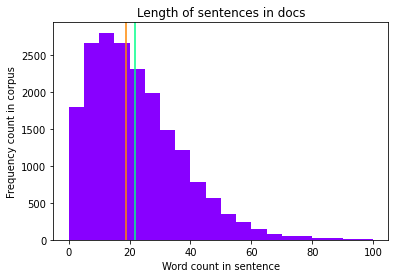

In [13]:
plt.hist(x = sent_lens, bins = 20, range = (0,100), color = "#8800ff"); # exclude some positive outliers
plt.xlabel("Word count in sentence")
plt.ylabel("Frequency count in corpus")
plt.axvline(x = np.mean(sent_lens), color = "#00ff88")
plt.axvline(x = np.median(sent_lens), color = "#ff8800")
plt.title(label = "Length of sentences in docs");

print(f"The median number of words in a sentence is: {round(np.median(sent_lens),2)}")
print(f"The mean number of words in a sentence is: {round(np.mean(sent_lens),2)}")
print("\n")

> ### The skew here is not as drastic as I expected. Possibly due to common writing styles and techniques used in online news articles.

## Visualize distribution of number of sentences in documents

In [14]:
sents_in_docs = [] # create list of ints representing the number of sentences in every doc
for doc in docs_as_sents:
    sents_in_docs.append(len(doc))

The median number of sentences in a doc is: 38.0
The mean number of sentences in a doc is: 51.95




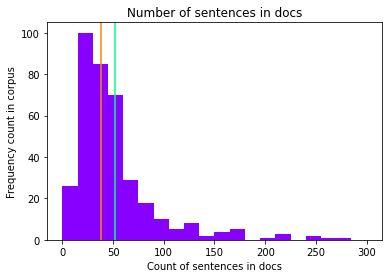

In [15]:
plt.hist(x = sents_in_docs, bins = 20, range = (0, 300), color = "#8800ff"); # exclude some positive outliers
plt.xlabel("Count of sentences in docs")
plt.ylabel("Frequency count in corpus")
plt.axvline(x = np.mean(sents_in_docs), color = "#00ff88")
plt.axvline(x = np.median(sents_in_docs), color = "#ff8800")
plt.title(label = "Number of sentences in docs");

print(f"The median number of sentences in a doc is: {round(np.median(sents_in_docs),2)}")
print(f"The mean number of sentences in a doc is: {round(np.mean(sents_in_docs),2)}")
print("\n")

> ### There are roughly 52 sentences in each news article although the data is right-skewed with a long tail.

# <span style="color:#FF8800"> Load labels
> ### Here we'll use another file from the training data to get the spans and the span labels for the training data.

In [16]:
from spacy.tokens import Doc, Token, Span
Span.set_extension("TRAIN_LABEL", default = "No_Label")

In [17]:
%%time

docs_as_docs = [] # create list where elements are separate docs, diff from above
for doc in nlp.pipe(texts):
    docs_as_docs.append(doc)

CPU times: user 16.7 s, sys: 4.97 s, total: 21.7 s
Wall time: 21.8 s


## Create df to map file num, filename, and order in which file was processed.

In [18]:
file_num_name_df = pd.DataFrame(text_num, columns = ["element_in_list", "filename"])

In [19]:
import re

In [20]:
file_num_name_df["filenumber"] = file_num_name_df.apply(lambda x: int(re.findall("\d+", x["filename"])[0]), axis = 1) # extract unique file number from filename
file_num_name_df = file_num_name_df[["filenumber","filename","element_in_list"]] # change order of cols

In [21]:
TRAIN_LABELS = "datasets/train-task2-TC.labels"

In [22]:
all_spans_df = pd.read_csv(TRAIN_LABELS, sep = "\t", header = None, names = ["filenumber","label","span_start","span_end"])
all_spans_df["span_len"] = all_spans_df.apply(lambda x: x["span_end"]-x["span_start"], axis = 1)

all_spans_viz = pd.DataFrame(all_spans_df.groupby("label").mean()["span_len"]) # df for visualizing counts & lens of spans

counts_df = pd.DataFrame(data = all_spans_df["label"].value_counts()) # get label counts

all_spans_viz = all_spans_viz.merge(counts_df, left_index=True, right_index=True)
all_spans_viz.rename(columns = {"label":"count"}, inplace = True)

## Visualize counts of labels

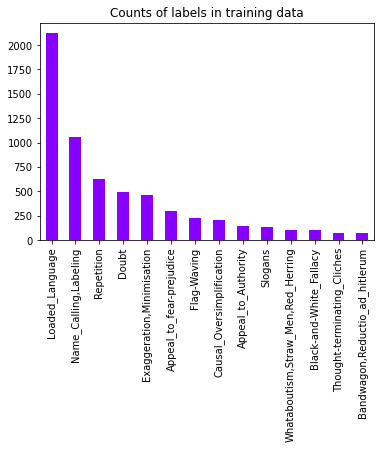

In [23]:
all_spans_viz["count"].sort_values(ascending = False).plot.bar(color = "#8800ff");
plt.title("Counts of labels in training data");

> ### The training data is imbalanced, the clear majority of spans are "Loaded_Language" and there is a long tail.

## Visualize mean span length for labels

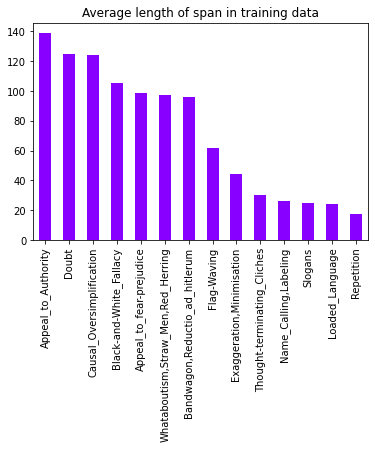

In [24]:
all_spans_viz["span_len"].sort_values(ascending = False).plot.bar(color = "#8800ff");
plt.title("Average length of span in training data");

> ### Some types of propaganda are quite long, almost 140 tokens in length.

## Visualize exact span lengths for labels

In [25]:
round(all_spans_viz["span_len"].sort_values(ascending = False),2)

Appeal_to_Authority                   138.96
Doubt                                 124.80
Causal_Oversimplification             123.98
Black-and-White_Fallacy               105.30
Appeal_to_fear-prejudice               98.59
Whataboutism,Straw_Men,Red_Herring     97.15
Bandwagon,Reductio_ad_hitlerum         96.28
Flag-Waving                            61.88
Exaggeration,Minimisation              44.14
Thought-terminating_Cliches            30.47
Name_Calling,Labeling                  26.33
Slogans                                25.09
Loaded_Language                        24.49
Repetition                             17.78
Name: span_len, dtype: float64

> ### The range for propaganda length is relatively large, a difference of approximately 123 tokens.

# <span style="color:#FF8800"> Assign labels to spans

In [26]:
all_spans_df = all_spans_df.merge(file_num_name_df, on = "filenumber") # this is our main df with all span details

In [27]:
all_spans_df.sample(3)

,filenumber,label,span_start,span_end,span_len,filename,element_in_list
4982,786731884,Causal_Oversimplification,2462,2574,112,article786731884.txt,133
1872,732610971,Repetition,200,223,23,article732610971.txt,270
279,697959084,Thought-terminating_Cliches,2647,2664,17,article697959084.txt,200


> ### Above is a sample of our main DataFrame. We'll use it to set the spaCy char_spans and labels.

In [28]:
for row in all_spans_df.iterrows():
    try:
        row_temp = row[1]
        docs_as_docs[row_temp["element_in_list"]].char_span(row_temp["span_start"], row_temp["span_end"])._.TRAIN_LABEL = row_temp["label"]
    except Exception as e:
        pass

> ### For each row in the DataFrame we'll attempt to assign the indicated label to the character span.
> ### Some of the char_span assignments throw errors. It's a minority of cases (approx. 26) mostly due to missing/wrong spans. This try except is a workaround.

In [29]:
docs_as_docs[272].char_span(3954, 3973), docs_as_docs[272].char_span(3954, 3973)._.TRAIN_LABEL

(too good to be true, 'Thought-terminating_Cliches')

In [30]:
docs_as_docs[64].char_span(8612, 8882), docs_as_docs[64].char_span(8612, 8882)._.TRAIN_LABEL

(They [Guardian editors] knew that publishing this story would cause partisan warriors to excitedly spread the story, and that cable news outlets would hyperventilate over it, and that they’d reap the rewards regardless of whether the story turned out to be true or false,
 'Doubt')

In [31]:
docs_as_docs[153].char_span(823, 865), docs_as_docs[153].char_span(823, 865)._.TRAIN_LABEL

(Trump's gut-driven, norm-shattering tenure, 'Name_Calling,Labeling')

> ### Above are three examples from the spans we've labeled.

## <span style="color:#8800ff"> Create & label negative spans
> ### The training data only contains details on positive spans. The rest of the news article can effectively be treated as negative spans (i.e. segments without propaganda). Since we'll likely want to train our "downstream" classifiers on both positive and negative samples we can assign the negative spans with their own label of "No_Propaganda". 

In [32]:
from intervaltree import Interval, IntervalTree

In [33]:
%%time

neg_spans_list = [] # create a list of nested tuples
errors = []
CONTEXT_WINDOW = 75

for entry in all_spans_df["element_in_list"].unique(): # iterate through unique entries in element_in_list
    sub_df = all_spans_df[all_spans_df["element_in_list"]==entry] # this is subset of main df containing only entries for the current doc
    these_intervals = [(x[1]["span_start"], x[1]["span_end"]) for x in sub_df.iterrows()] # get intervals
    this_tree = IntervalTree.from_tuples(these_intervals) # initialize tree with intervals
    
    this_doc = docs_as_docs[entry]
    START_POINT = CONTEXT_WINDOW # char position we can start from
    END_POINT = len(this_doc)-(CONTEXT_WINDOW) # char position we can work up until
    for token in range(START_POINT, END_POINT): # for the range of possible center positions of the CONTEXT_WINDOW
        if this_tree.overlap(token, token+CONTEXT_WINDOW):
            continue
        else:
            try:
                docs_as_docs[entry].char_span(token, token+CONTEXT_WINDOW)._.TRAIN_LABEL = "No_Propaganda"
                neg_spans_list.append((entry, (token,token+CONTEXT_WINDOW)))
            except Exception as e:
                errors.append(entry)

CPU times: user 4.16 s, sys: 3.06 ms, total: 4.17 s
Wall time: 4.16 s


In [34]:
len(neg_spans_list)

9825

> ### We've created 9,825 negative spans using the training data.

In [35]:
docs_as_docs[46].char_span(161,236), docs_as_docs[46].char_span(161,236)._.TRAIN_LABEL

(have been brought under control in Madagascar, but warned the next outbreak,
 'No_Propaganda')

> ### Above is an example of one of the spans and the label that's been assigned to it.

## Collect all positive and negative spans

In [36]:
full_list = [(docs_as_docs[i[0]].char_span(i[1][0],i[1][1]).text,"No_Propaganda") for i in neg_spans_list] # simpler to supply "No_Propaganda" label than retrieve it from the char_span

In [37]:
for i in all_spans_df.iterrows():
    try:
        full_list.append((docs_as_docs[i[1]["element_in_list"]].char_span(i[1]["span_start"],i[1]["span_end"]).text, i[1]["label"])) # here the labels may be different so better to retrieve it from the char_span
    except Exception as e:
        pass

In [38]:
train_df = pd.DataFrame.from_records(full_list, columns = ['text','label'])
train_df["label_binary"] = train_df.apply(lambda x: "No_Propaganda" if x["label"] == "No_Propaganda" else "Propaganda", axis = 1) # create new col that is binary flag of "propaganda vs no propaganda"

## Visualize counts of Propaganda vs. No_Propaganda in training data

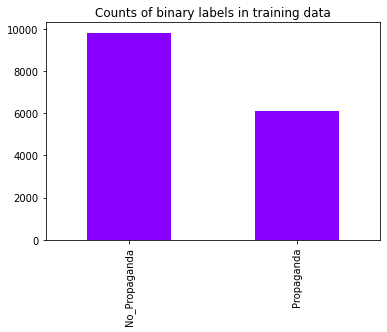

In [39]:
train_df["label_binary"].value_counts().plot.bar(color = "#8800ff");
plt.title("Counts of binary labels in training data");

> ### We have an imbalance in the training data. Is this representative of actual news articles? Propaganda seems overrepresented.

In [40]:
train_df["label_binary"].value_counts(normalize=False)

No_Propaganda    9825
Propaganda       6103
Name: label_binary, dtype: int64

> ### <span style="color:#8800ff"> We can increase our training data by 160% 🙂
> #### Which is exactly what we'll do in a separate notebook.

## Exact counts of Propaganda vs. No_Propaganda in training data

In [41]:
round(train_df["label_binary"].value_counts(normalize=True)*100,2)

No_Propaganda    61.68
Propaganda       38.32
Name: label_binary, dtype: float64

> ### <span style="color:#8800FF"> Approximately four out of every ten sentences contains an instance of propaganda. In terms of the training data being representative of an "average online news article" this strikes me as far too high. I would expect something more like 0.25 (or fewer) out of every ten sentences containing propaganda however, I have no justification for that number. It's possible that propaganda is more common than I am inclined to think.   
> ### <span style="color:#8800FF"> If we wanted to generalize any "downstream" classifiers to random news articles it's possible that the classifiers would predict *some* propaganda label more frequently than they should resulting in a higher number of false positives simply due to the training data. However, one clear benefit of this approach, as opposed to collecting new negative samples on our own, is that we can be highly confident that the negative samples are truly negative samples. If we collected our own news articles at random we'd likely have some instances of actual propaganda labeled as "No_Propaganda".

## Visualize counts of all labels in training data

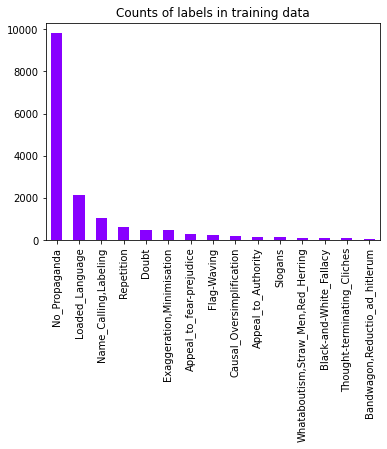

In [42]:
train_df["label"].value_counts().plot.bar(color = "#8800ff");
plt.title("Counts of labels in training data");

> ### Majority of spans don't contain propaganda and there is a long tail.

## Proportions for all labels in training data

In [43]:
round(train_df["label"].value_counts(normalize=True)*100,2)

No_Propaganda                         61.68
Loaded_Language                       13.28
Name_Calling,Labeling                  6.62
Repetition                             3.88
Doubt                                  3.08
Exaggeration,Minimisation              2.92
Appeal_to_fear-prejudice               1.83
Flag-Waving                            1.43
Causal_Oversimplification              1.31
Appeal_to_Authority                    0.89
Slogans                                0.81
Whataboutism,Straw_Men,Red_Herring     0.68
Black-and-White_Fallacy                0.67
Thought-terminating_Cliches            0.47
Bandwagon,Reductio_ad_hitlerum         0.45
Name: label, dtype: float64

> ### Most positive labels are quite rare individually accounting for much less than 5% of the data.

# <span style="color:#FF8800"> Compare linguistic features of positive and negative spans
> ### As a final step in our exploratory data analysis we'll check some linguistic features of the positive and negative spans to see how they compare.

In [44]:
import textstat

train_df["sent_count"] = train_df.apply(lambda x: textstat.sentence_count(x["text"]), axis = 1) # number of sentences in span
train_df["flesch_reading"] = train_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis = 1) # Flesch reading ease score, higher is easier to read
train_df["difficult_words"] = train_df.apply(lambda x: textstat.difficult_words(x["text"]), axis = 1) # count of words with 2 or more syllables, seems like low threshold
train_df["read_index"] = train_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis = 1) # approximates the grade level needed to comprehend the text
train_df["syllable_count"] = train_df.apply(lambda x: textstat.syllable_count(x["text"]), axis = 1) # count of the number of syllables in the given text
train_df["text_standard"] = train_df.apply(lambda x: textstat.text_standard(x["text"], float_output = True), axis = 1) # combines a number of readability scores, the estimated school grade level to understand text
train_df["text_len"] = train_df.apply(lambda x: len(x["text"]), axis=1) # the length of the text

In [45]:
text_stats = round(train_df.groupby("label_binary").mean(),1)
text_stats.T

label_binary,No_Propaganda,Propaganda
sent_count,1.2,1.1
flesch_reading,67.2,44.5
difficult_words,3.2,2.2
read_index,8.3,10.7
syllable_count,18.8,12.6
text_standard,7.8,7.9
text_len,75.0,48.3


> ### <span style="color:#8800ff"> We can see that texts featuring propaganda are shorter (text_len), more difficult to read (flesch_reading, lower is harder to understand), and contain fewer syllables (syllable_count) than texts without propaganda.

# <span style="color:#FF8800"> END